<a href="https://colab.research.google.com/github/yodavo/IAI_vaccines/blob/main/data_wrangling/dataWranglingVAERS(David).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Paquetes

In [242]:
# Instalar paquetes no disponibles
!pip install squarify
!pip install fuzzywuzzy

# Para importar la data
import os

# Importar para manipulacion de datos
import numpy as np
import pandas as pd
from statistics import *

# Importar para Visualizacion 
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import warnings # para evitar warnings
warnings.filterwarnings('ignore')
import textwrap
from textwrap import wrap
import squarify
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

# Importar Dependencias
%matplotlib inline
%load_ext google.colab.data_table

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


# Carga de datos

In [367]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [368]:
# Carga de datos
%cd '/content/drive/MyDrive/Colab Notebooks/Diplomado-UTEC/Modulo5/dataset'

data = pd.read_csv('2021VAERSData.csv', index_col=0, encoding='latin-1')
symptom = pd.read_csv('2021VAERSSYMPTOMS.csv', index_col=0, encoding='latin-1')

print(data.shape)
print(symptom.shape)

/content/drive/MyDrive/Colab Notebooks/Diplomado-UTEC/Modulo5/dataset
(428486, 34)
(575022, 10)


# Preparacion de datos de vacunas (**VAERSVAX**)

In [369]:
# importar la info
vax = pd.read_csv('2021VAERSVAX.csv', index_col=0, encoding='latin-1')
vax.shape

(445358, 7)

In [370]:
# TRATANDO VAX
vac = vax.loc[vax['VAX_MANU'] != 'UNKNOWN MANUFACTURER'] # eliminamos frabricante desconocido
vac = vac.loc[vac['VAX_TYPE'] == 'COVID19'] # seleccionamos solamente los datos de covid19
vac.shape

(437645, 7)

In [371]:
# eliminamos repetidos
vacuna = vac.loc[vac.index.drop_duplicates(keep=False)]
vacuna.shape # no duplicados, lista para ser combinada

(409006, 7)

In [372]:
# separando el dataset de vacunas de covid19
print(f"Tamaño dataset original: {vax.shape[0]} observaciones")
print(f"Tamaño dataset COVID19: {vacuna.shape[0]} observaciones")

Tamaño dataset original: 445358 observaciones
Tamaño dataset COVID19: 409006 observaciones


# Merge de datasets **VAERVAX** (vacuna) y **VAERSData** (data), basada en 'vacuna' - variable global : **dataset_covid**

Lamentablemente, el dataset sympthoms esta contaminado con informacion de laboratorio, medicamenttos y otros. Por lo que no fue tomada en cuenta para el analisis.

In [373]:
dataset_covid = pd.merge(vacuna, data, on='VAERS_ID')
dataset_covid.shape

(409006, 41)

# **REVISION POR VARIABLE Y APLICACION DE FILTROS**

## **Variables que no aportan informacion para este estudio**

1. **RPT_DATE** -- Fecha del reporte, no es necesaria para este estudio
2. **SPLTTYPE** -- Numero de proyecto de fabricante, no es necesaria para este estudio.
3. **TODAYS_DATE** -- Fecha de subida a la base de datos, no es indispensable.
4. **VAX_MANU** -- Una vez realizado el filtro, no es necesaria. De ahora en adelante de usara VAX_NAME que tiene la misma informacion.


In [374]:
## Variables no necesarias
rejected_col = ['RPT_DATE', 'SPLTTYPE', 'TODAYS_DATE', 'VAX_MANU']
print(f"Antes: {dataset_covid.shape[0]} observaciones y {dataset_covid.shape[1]} variables")
dataset_covid.drop(rejected_col, axis=1, inplace=True)
print(f"Despues: {dataset_covid.shape[0]} observaciones y {dataset_covid.shape[1]} variables")

Antes: 409006 observaciones y 41 variables
Despues: 409006 observaciones y 37 variables


## **Variables que necesitan observación por el metodo de coleccion de datos**

En la colecta de los datos, tenemos dos factores importantes, primero la naturaleza del formulario que se utilizo para **(FORM_VERS)** teniendo dos formularios:

1. Form1 - Impreso (289 observaciones)
2. Form2 - Online (408717 observaciones)

Como observamos la version impresa tiene una cantidad no significativa en comparacion de los otros datos. **Lo que nos permite eliminarla.**

En consecuencia de la eliminacion de los formularios 1, existen otras variables tomadas juntamente con este formato. Por lo que tambien fueron eliminadas. Se elimino **V_FUNDBY** (Tipos de financiamiento usado para la vacunación) por poseer data insuficiente.

Segundo, se tenia la variable **HISTORY** (Condiciones cronicas y enfermedades duraderas reportadas), al momento de analizar la informacion se vio una cantidad de datos considerable por lo que se creo un diccionario de palabras a ignorar (**palabras_erroneas**, este mismo sera actualizado en cada variable que reciba variables textuales) y se observo si las variables tenian un valor significativo en el dataset, no fue eliminada.

Tercero, se reviso la variable **VAX_DOSE_SERIES** que no era confiable debido a su descontinuacion en algunos formularios.  Primero se elimimino las observaciones (fila entera) donde se observo mas de 3 dosis de vacunas. Entre estos casos excedentes se observo: 

- MODERNA (644)
- PFIZER-BIONTECH (585)
- JANSSEN (85)

Reportando 11 fallecidos (por Moderna y Pfizer) y 17 hospitalizados por todas las vacunas (para mas detalle ver el codigo abajo).






In [375]:
# eliminar variables FORM_VERS (ya que todos los datos son del formato online - Form2) y
# se elimino VFUNDBY que estaba relacionado con los Form1
rejected_col = ['FORM_VERS', 'V_FUNDBY']
print(f"Antes: {dataset_covid.shape[0]} observaciones y {dataset_covid.shape[1]} variables")
dataset_covid.drop(rejected_col, axis=1, inplace=True)
print(f"Despues: {dataset_covid.shape[0]} observaciones y {dataset_covid.shape[1]} variables")

Antes: 409006 observaciones y 37 variables
Despues: 409006 observaciones y 35 variables


In [376]:
# sintesis de listas de palabras a ignorar.
palabras_errones = ['none', 'no', 'comments: unknown', 'unknown',
                    'comments: list of non-encoded patient relevant history: patient other relevant history 1: none',
                    'medical history/concurrent conditions: no adverse event (no reported medical history)', 
                    'none reported', 'medical history/concurrent conditions: no adverse event (no medical history reported)',
                    'medical history/concurrent conditions: no adverse event (no reported medical history.)',
                    'none known', 'na', 'medical history/concurrent conditions: no adverse event (no medical history reported.)',
                    'none listed', 'unk', 'comments: the patient had no known allergies.', 'no.', 
                    '0', 'non', 'yes', 'none noted', 'none stated', 'no known', 'comments: list of non-encoded patient relevant history: patient other relevant history 1: no',
                    'nothing', 'comments: no medical history was provided by the reporter.',
                    'comments: list of non-encoded patient relevant history: patient other relevant history 1: no',
                    'comments: the patient had no known drug allergies.', 'nothing'
]

In [377]:
# analisis de HISTORY
dataset_covid['HISTORY'] = dataset_covid['HISTORY'].str.lower().replace(palabras_errones, np.nan) # reemplazando valores incorrectos
dataset_covid.HISTORY.dropna().value_counts().sum() # revision de cantidad de valores utiles

179568

In [378]:
# analisis de VAX_DOSE_SERIES
dataset_covid['VAX_DOSE_SERIES'] = dataset_covid['VAX_DOSE_SERIES'].str.lower().replace('unk', np.nan) # reemplazando valores desconocidos (UNK)

# revision de dosis exageradas (ESTA SECCION ES SOLO PARA REPORTE, LOS DATOS SE ELIMINARON DE LA BASE DE DATOS)
outliers_dosis = dataset_covid.loc[dataset_covid['VAX_DOSE_SERIES'].isin(['4', '5', '6', '7+'])]
print(f'Valores fuera de los rangos de estudio: \n')
print(outliers_dosis.VAX_NAME.value_counts())
print(f'\nValores de fallecidos: \n')
print(outliers_dosis.groupby(['VAX_NAME', 'DIED']).size())
print(f'\nValores de hospitalizados: \n')
print(outliers_dosis.groupby(['VAX_NAME', 'HOSPITAL']).size())

# eiminar valores de dosis excedentes
print(f"\n\nAntes: {dataset_covid.shape[0]} observaciones y {dataset_covid.shape[1]} variables")
dataset_covid = dataset_covid[~dataset_covid['VAX_DOSE_SERIES'].isin(['4', '5', '6', '7+'])]
print(f"Despues: {dataset_covid.shape[0]} observaciones y {dataset_covid.shape[1]} variables")

Valores fuera de los rangos de estudio: 

COVID19 (COVID19 (MODERNA))            278
COVID19 (COVID19 (PFIZER-BIONTECH))    110
COVID19 (COVID19 (JANSSEN))             61
Name: VAX_NAME, dtype: int64

Valores de fallecidos: 

VAX_NAME                             DIED
COVID19 (COVID19 (MODERNA))          Y       9
COVID19 (COVID19 (PFIZER-BIONTECH))  Y       2
dtype: int64

Valores de hospitalizados: 

VAX_NAME                             HOSPITAL
COVID19 (COVID19 (JANSSEN))          Y            2
COVID19 (COVID19 (MODERNA))          Y           11
COVID19 (COVID19 (PFIZER-BIONTECH))  Y            4
dtype: int64


Antes: 409006 observaciones y 35 variables
Despues: 408557 observaciones y 35 variables


In [379]:
dataset_covid.shape

(408557, 35)

## **Filtrado de Variables.**

1. **RECVDATE** -- Fecha de ingreso de reporte.

**1.RECVDATE**

In [380]:
# Procesamiento de RECVDATE, formato de fecha
dataset_covid['RECVDATE'] =  dataset_covid['RECVDATE'].apply(pd.to_datetime, format='%m/%d/%Y') # no contiene ningun valor vacio

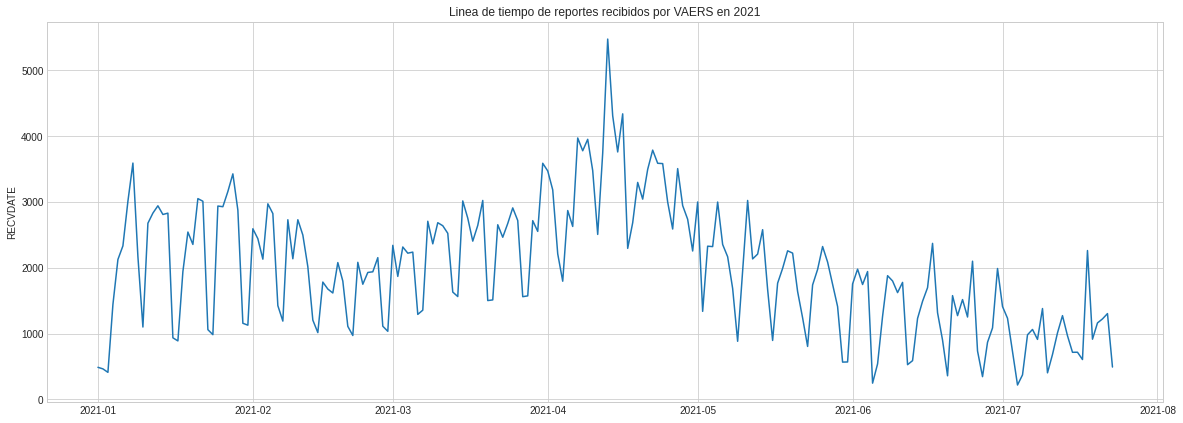

In [381]:
# variable para plotear
recvdate = dataset_covid['RECVDATE'].value_counts()

# grafico de fecha de ingreso de reportes
plt.figure(figsize=(20,7))
sns.lineplot(data = recvdate)
plt.title('Linea de tiempo de reportes recibidos por VAERS en 2021')
plt.show()


**2. STATE**

In [382]:
# Lista  de estados de los Estados Unidos de America
usa_states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

In [383]:
xxx = dataset_covid.copy()

In [395]:
# Obteniendo datos erroneos para correcion
dataset_covid['STATE'] = dataset_covid['STATE'].str.upper() # volver tod el codigo a mayusculas
dataset_covid['STATE'] = dataset_covid['STATE'].str.strip() # quitar espacios en blanco
erroneo = dataset_covid['STATE'].value_counts().index.tolist() # seleccionar valores para comparar con los estados
cambio = list(set(erroneo) - set(usa_states)) # ver la diferencia}
cambio

['FM', 'XB', 'AS', 'VI', 'GU', 'XV', 'QM', 'XL', 'PR', 'MH', 'MP']

In [398]:
## PR == PUERTO RICO
## 
dataset_covid.loc[dataset_covid['STATE']=='FM']

,VAX_TYPE,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,VAX_NAME,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,SYMPTOM_TEXT,DIED,DATEDIED,L_THREAT,ER_VISIT,HOSPITAL,HOSPDAYS,X_STAY,DISABLE,RECOVD,VAX_DATE,ONSET_DATE,NUMDAYS,LAB_DATA,V_ADMINBY,OTHER_MEDS,CUR_ILL,HISTORY,PRIOR_VAX,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES
VAERS_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1034555,COVID19,NaN,2,IM,RA,COVID19 (COVID19 (MODERNA)),2021-02-16,FM,29.0,29.0,NaN,F,1 dose (1/14/2021) - just having a low grade f...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,U,01/14/2021,01/20/2021,6.0,I did go to medical facility.,PUB,"normally, i am taking loratadine for allergies...","no,","kidney stones, and hormonal imbalance",NaN,NaN,NaN,NaN,"midol, or some kind with ibuprofen content se..."
1064355,COVID19,007M20A,1,IM,LA,COVID19 (COVID19 (MODERNA)),2021-03-01,FM,58.0,58.0,NaN,F,Blurring of vision of the right eye few hours ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,N,02/17/2021,02/17/2021,0.0,Physical examination revealed visual acuity in...,PUB,None,None,NaN,NaN,NaN,Y,NaN,None
1206410,COVID19,024M20A,1,IM,LA,COVID19 (COVID19 (MODERNA)),2021-04-14,FM,19.0,19.0,NaN,M,The patient experienced 5/10 bilateral frontop...,NaN,NaN,NaN,NaN,Y,5.0,NaN,NaN,Y,04/02/2021,04/06/2021,4.0,"CBC and platelet count (4/9/21) WBC 8.9, hemog...",PVT,NONE,NONE,NaN,NaN,NaN,NaN,NaN,NONE


In [399]:
dataset_covid.DISABLE.value_counts()

Y    5581
Name: DISABLE, dtype: int64

In [ ]:
# Observando algunas variables

print(dataset_covid['STATE'].value_counts()) # raro, solo hay 50 estados
print(dataset_covid['STATE'].sort_values().unique()) # revisar

CA    60086
NY    32565
FL    32093
TX    31625
IN    26200
      ...  
XB        9
XL        6
FM        6
XV        4
QM        2
Name: STATE, Length: 62, dtype: int64
['AK' 'AL' 'AR' 'AS' 'AZ' 'CA' 'CO' 'CT' 'DC' 'DE' 'FL' 'FM' 'GA' 'GU'
 'HI' 'IA' 'ID' 'IL' 'IN' 'KS' 'KY' 'LA' 'MA' 'MD' 'ME' 'MH' 'MI' 'MN'
 'MO' 'MP' 'MS' 'MT' 'NC' 'ND' 'NE' 'NH' 'NJ' 'NM' 'NV' 'NY' 'OH' 'OK'
 'OR' 'PA' 'PR' 'QM' 'RI' 'SC' 'SD' 'TN' 'TX' 'UT' 'VA' 'VI' 'VT' 'WA'
 'WI' 'WV' 'WY' 'XB' 'XL' 'XV' nan]


# NLP en SYMTOMS_TEXT

In [99]:
data = pd.read_csv('2021VAERSData.csv', index_col=0, encoding='latin-1')

In [100]:
sintomas_objetivo = ['vaccine-associated enhanced disease', 'multisystem inflammatory syndrome in children', 'acute respiratory distress syndrome',
                     'acute cardiovascular injury', 'microangiopathy', 'heart failure', 'stress cardiomyopathy', 'coronary artery disease arrhythmia',
                     'myocarditis', 'Coagulation disorder', 'thromboembolism', 'haemorrhage', 'Acute kidney injury', 'Generalized convulsion', 
                     'Acute liver injury', 'anosmia','ageusia', 'Chilblain', 'lesion', 'Single organ cutaneous vasculitis', 'Erythema multiforme', 
                     'Anaphylaxis', 'Acute aseptic arthritis', 'Meningoencephalitis', 'Acute disseminated encephalomyelitis', 'Thrombocytopenia'
                     ]
sintomas_objetivo = list(map(str.lower,sintomas_objetivo))
sintomas_objetivo.sort()

In [101]:
# Trabajando en Text
data.SYMPTOM_TEXT.fillna('None',inplace=True) #rellenar nan
data.SYMPTOM_TEXT = data.SYMPTOM_TEXT.str.lower() # convertir en minuscula
data.SYMPTOM_TEXT = data.SYMPTOM_TEXT.str.replace('[^\w\s]',' ') # limpiar signos
data.SYMPTOM_TEXT = data.SYMPTOM_TEXT.str.rstrip() # limpiar espacios antes
data.SYMPTOM_TEXT = data.SYMPTOM_TEXT.str.lstrip() # limpiar especio despues

In [141]:
prueba = data.head(10000)

In [ ]:
from fuzzywuzzy import fuzz

for i in sintomas_objetivo:
  prueba[i] = ""
  print('Sintoma: ', i)
  for j in prueba.SYMPTOM_TEXT:
    if fuzz.partial_ratio(i,j) > 80:
      print(i,'---',j)
      prueba[i,j] = 1
    else:
      prueba[i] = 0

In [61]:
data.loc[data.SYMPTOM_TEXT.str.contains('hrombocytopenia', na=False)].shape

(658, 34)

In [ ]:
symptom.head(100)

In [ ]:
symptom.SYMPTOM1

In [9]:
sympotom1.value_counts().head(100)

In [ ]:
symptom[symptom.SYMPTOM1.str.contains('oagulopathy')]

# Tratamiento de Variables

In [ ]:
# revisando las fechas
temp = pd.DataFrame()
temp['ONSET_DATE'] = dataset_covid['ONSET_DATE'].copy()
temp['ONSET_DATE'].isna().sum() # no nan
new = temp["ONSET_DATE"].str.split("/", n = 2, expand = True)
temp["month"]= new[0]
temp["day"]= new[1]
temp["year"]= new[2]

In [ ]:
print(temp.month.value_counts().sort_index())
print(temp.day.value_counts().sort_index())
print(temp.year.value_counts().sort_index())

In [ ]:
# Actualizando datetime
dtime = ['RECVDATE', 'DATEDIED', 'VAX_DATE', 'ONSET_DATE']
dataset_covid[dtime] =  dataset_covid[dtime].apply(pd.to_datetime, format='%m/%d/%Y')

In [ ]:
# revisando la naturaleza de los datos
dataset_covid.info()

In [ ]:
# Revision de duplicados
obs_real = dataset_covid.index.drop_duplicates().shape[0]
obs_colectada = dataset_covid.index.shape[0]
print(f"Observaciones unicas: {obs_real}")
print(f"Los valores unicos son {(obs_real/obs_colectada*100):.2f} % de la data colectada,\ncon {obs_colectada - obs_real} datos que pueden ser diferentes dosis.")

Observaciones unicas: 424214
Los valores unicos son 71.75 % de la data colectada,
con 167027 datos que pueden ser diferentes dosis.


In [ ]:
# Analisis por edad
dataset_covid.AGE_YRS.fillna(0).astype(int).value_counts().sort_index(ascending=False)

119        2
115        5
113        1
106        1
105        7
       ...  
4          9
3          9
2          6
1         50
0      33018
Name: AGE_YRS, Length: 110, dtype: int64

In [ ]:
# Analisis por edad aparente
dataset_covid.CAGE_YR.fillna(0).astype(int).value_counts().sort_index(ascending=False) # no son valores similares...

120        7
119        4
118        2
113        1
106        1
       ...  
4          1
3          1
2          1
1         17
0      81836
Name: CAGE_YR, Length: 110, dtype: int64

In [ ]:
# Analisis por mes aparente, esto necesita un suma no es muy clara...
dataset_covid.CAGE_MO.dropna().shape # Posiblemente desestimada..-

(936,)

In [ ]:
# Analisis por sexo
dataset_covid.SEX.value_counts()

F    418524
M    161053
U     11664
Name: SEX, dtype: int64

In [ ]:
# Analisis textual de los sintomas, considerable numero...
dataset_covid.SYMPTOM_TEXT.unique().shape

(404024,)

In [ ]:
# Data de Personas fallecidas = 9434 ..... FECHAS ERRADAS!
dataset_covid.DATEDIED.value_counts().sort_index()

2001-01-08     1
2010-03-14     1
2014-02-14     2
2020-05-31     2
2020-12-01     1
              ..
2021-07-17     7
2021-07-18     3
2021-07-19    13
2021-07-20     1
2021-07-21     6
Name: DATEDIED, Length: 218, dtype: int64

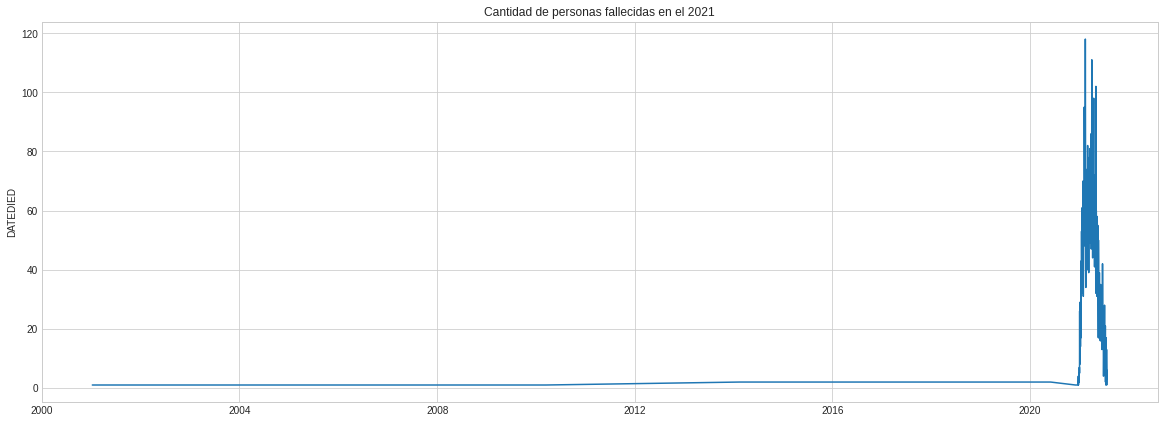

In [ ]:
died = dataset_covid.DATEDIED.value_counts()
died
# grafico de personas fallecidas
plt.figure(figsize=(20,7))
sns.lineplot(data = died)
plt.title('Cantidad de personas fallecidas en el 2021')
plt.show()

In [ ]:
# revission de categoricas
# enfermedad terminal
dataset_covid.L_THREAT.value_counts()

Y    16254
Name: L_THREAT, dtype: int64

In [ ]:
# hospitalizacion = 53726
dataset_covid.HOSPDAYS = dataset_covid.HOSPDAYS.replace([99999,999], np.nan) # incorrect values
dataset_covid.HOSPDAYS.dropna().astype(int).value_counts().sort_index(ascending=False)

120       6
117       1
104       3
97        2
95        2
       ... 
5      3173
4      4394
3      6736
2      8407
1      6889
Name: HOSPDAYS, Length: 76, dtype: int64

In [ ]:
# recuperados?
dataset_covid.RECOVD.value_counts()

N    238666
Y    205958
U     96928
Name: RECOVD, dtype: int64

In [ ]:
# Dia del vacuna.... FECHAS ERRADAS!
dataset_covid.VAX_DATE.value_counts().sort_index()

1920-01-18      1
1921-01-01      1
1921-01-06      2
1921-01-07      2
1921-01-09      1
             ... 
2021-07-18    107
2021-07-19    244
2021-07-20    256
2021-07-21    183
2021-07-22    122
Name: VAX_DATE, Length: 861, dtype: int64

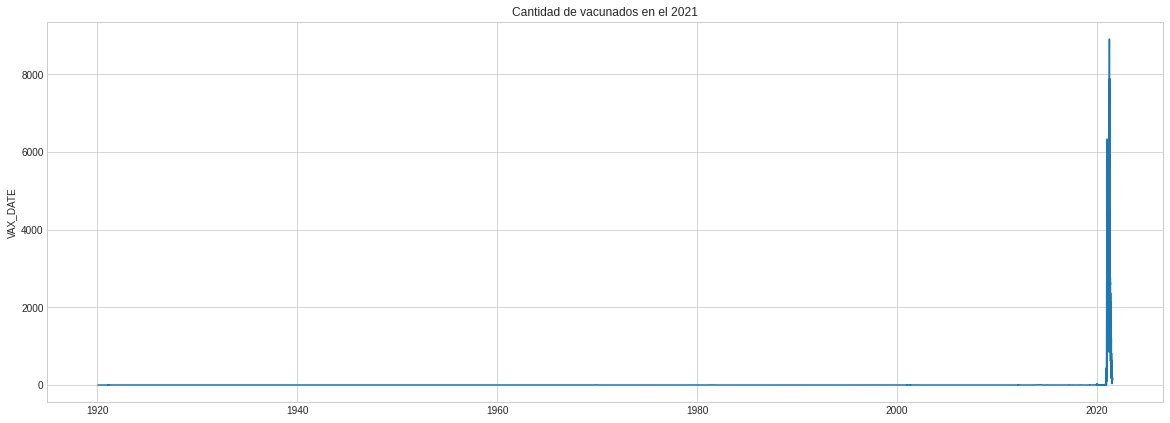

In [ ]:
vacunados = dataset_covid.VAX_DATE.value_counts()
# grafico de personas fallecidas
plt.figure(figsize=(20,7))
sns.lineplot(data = vacunados)
plt.title('Cantidad de vacunados en el 2021')
plt.show()

In [ ]:
# Dia de efecto adverso.... FECHAS ERRADAS!
dataset_covid.ONSET_DATE.value_counts().sort_index()

1920-12-23      2
1920-12-25      4
1920-12-29      3
1921-01-05      1
1921-01-06      1
             ... 
2021-07-18    202
2021-07-19    349
2021-07-20    334
2021-07-21    262
2021-07-22    170
Name: ONSET_DATE, Length: 478, dtype: int64

In [ ]:
# numero de dias desde el dia del efecto adverso # aqui hay datos ERRADOS!!
dataset_covid.NUMDAYS.dropna().astype(int).value_counts().sort_index(ascending=False)

36896         1
36573         1
36564         2
36561         1
36555         1
          ...  
4         11932
3         17836
2         31490
1        122758
0        232163
Name: NUMDAYS, Length: 595, dtype: int64

In [ ]:
# Trabajo de Laboratorio -- MALA variable
removew = ['unknown', 'no', 'n/a', 'na', 'none yet', 'see above',
       'none at this time', 'none.', 'none to date', 'none yet.',
       'none reported', 'none so far', 'none known', 'not applicable',
       'none at this time.', 'blood work', 'see above.', 'non', 'none done',
       '0', 'as above', 'ultrasound', 'none needed', 'no.',
       'none taken', 'no tests','as above.', 'n/a.','none performed',
       'none as of yet', 'unknown.', 'none so far.', 'not known', 'pending',
       'no e', 'none', 'vital signs', 'none to date.', 'not yet',
       '?', '-', 'vitals', 'lab work', 'unk', 'no tests done', 
       'nothing', 'none noted', 'unkown', 'none required', 'no tests.',
       'denies','unknown at this time', 'vitals were taken - normal',
       'no medical test']

dataset_covid['LAB_DATA'] = dataset_covid['LAB_DATA'].str.lower().replace(removew, np.nan) # incorrect values
dataset_covid.LAB_DATA.dropna().value_counts().head(100).index


Index(['ekg', 'covid test', 'ct scan',
       'test name: covid-19; test result: positive', 'mri',
       'test name: covid; test result: positive',
       'rt-pcr  or  other naat test', 'covid-19 test', 'covid-19 pcr',
       'covid test - negative',
       'test name: covid-19 test; test result: positive', 'yes',
       'test name: covid test; test result: positive', 'blood test',
       'test name: nasal swab; test result: negative', 'hearing test',
       'see #18', 'blood tests', 'cbc', 'bloodwork', 'see item 18', 'x-ray',
       'nine',
       'test name: blood pressure; result unstructured data: test result:high',
       '2/2/2021- cdc, cmp, lipase, ua, cxr.  covid negative, influenza negative.  wbc 8.2, hct 48.2, hgb 16.3, crp 4.9, na 135, k+ 4.0, chl 94, bicarb 33, bun 29, creatinine 0.8, glucose 145, alkaline phosphatase 106, lipase 24.   ua negative.    2/4/2021-   02/04 02/04 02/04  2145 2039 2039 blood gas      vbg ph (7.31 - 7.41)   6.99   vbg pco2 (40 - 50 mmhg)   73   v

In [ ]:
# Lugar donde se puso la vacuna
dataset_covid.V_ADMINBY.dropna().str.upper().value_counts(ascending = True)

MIL      8834
SEN     10884
SCH     11336
WRK     24509
PUB     70927
UNK    100865
PHM    102373
OTH    102622
PVT    158891
Name: V_ADMINBY, dtype: int64

In [ ]:
# Financiamiento para la vacuna
dataset_covid.V_FUNDBY.dropna().str.upper().value_counts(ascending = True)

PVT     19
PUB     53
UNK     82
OTH    211
Name: V_FUNDBY, dtype: int64

In [ ]:
# Otras medicaciones por historial
omeds = ['none', 'unknown', 'no', 'none.', 'n/a','unk', 'na','unk', 'na',
            'nothing', 'none listed', 'none reported','no medications',
            'unkown', 'no known', 'non', 'not reported', 'none noted', '0',
            'no.','not available']
removew += omeds

dataset_covid['OTHER_MEDS'] = dataset_covid['OTHER_MEDS'].str.lower().replace(removew, np.nan) # incorrect values
dataset_covid.OTHER_MEDS.value_counts()

levothyroxine                                                                                                                                                                                                                                       1346
tylenol                                                                                                                                                                                                                                             1302
birth control                                                                                                                                                                                                                                       1262
multivitamin                                                                                                                                                                                                                                        1103
synt

In [ ]:
# Otras medicaciones por historial
ill = ['none known', 'no illnesses', 'no acute illness', 'no acute illnesses', 
       'none known.', 'no known illnesses', 'unknown.', 'denied',
       'i did not have any other illnesses.', 'none stated', 'no other illnesses', 
       'not applicable', 'no other illnesses.','none reported.', '-', 'no e',
       'none per patient','none documented', 'zero', 'nonr', 'none disclosed',
       'no illnesses at the time of vaccination.', 'none that i am aware of',
       'no illnesses.', '?', 'nome', 'non-smoker', 'n/a.', 'nope',
       'no known illness', 'nothing acute', 'none indicated',
       'no other illnesses at the time of vaccination and up to one month prior.',
       'no illness date of vaccination, unknown prior', 'none acute', 
       'none that i know of', 'unsure','none identified', 'none,', 'nonw', 
       'none reported by patient', 'no other illness', 'no  other illnesses.']
removew += ill

dataset_covid['CUR_ILL'] = dataset_covid['CUR_ILL'].str.lower().replace(removew, np.nan) # incorrect values
dataset_covid.CUR_ILL.value_counts()

seasonal allergies                                                                                                                                          1055
asthma                                                                                                                                                       848
sinus infection                                                                                                                                              574
uti                                                                                                                                                          500
hypertension                                                                                                                                                 484
                                                                                                                                                            ... 
i have borderline  nonimmune syste

In [ ]:
# HISTORIAL MEDICO
historial = ['comments: list of non-encoded patient relevant history: patient other relevant history 1: none',
             'medical history/concurrent conditions: no adverse event (no reported medical history)',
             'medical history/concurrent conditions: no adverse event (no medical history reported)',
             'medical history/concurrent conditions: no adverse event (no reported medical history.)',
             'medical history/concurrent conditions: no adverse event (no medical history reported.)',
             'comments: no medical history was provided by the reporter.','not known', 'comments: unknown'
             ]
removew += historial

dataset_covid['HISTORY'] = dataset_covid['HISTORY'].str.lower().replace(removew, np.nan) # incorrect values
dataset_covid.HISTORY.value_counts()

asthma                                                        8838
high blood pressure                                           3884
hypertension                                                  3561
hypothyroidism                                                2572
diabetes                                                      1962
                                                              ... 
fibromyalgia, behcets, reynauds, cushings                        1
migraines, pcos/infertility                                      1
allergies and migraines                                          1
bundle branch block in heart                                     1
htn, non-hodgkin's lymphoma; pancreatitis; prostate cancer       1
Name: HISTORY, Length: 113806, dtype: int64

In [ ]:
# VACUNAS PREVIAS JAJJAJA
dataset_covid['PRIOR_VAX'] = dataset_covid['PRIOR_VAX'].str.lower().replace(removew, np.nan) # incorrect values
dataset_covid.PRIOR_VAX.value_counts()

flu shot                                                                                                                            388
flu vaccine                                                                                                                         354
flu                                                                                                                                 236
shingles                                                                                                                            221
influenza                                                                                                                           155
                                                                                                                                   ... 
one year with flu shot                                                                                                                1
anaphalatic shock from both penicillin and sulfa

In [ ]:
# FORMULARIOS DE COLECTA DE DATOS
dataset_covid.FORM_VERS.value_counts()

2    590876
1       365
Name: FORM_VERS, dtype: int64

In [ ]:
# VACUNAS PREVIAS

# nka = not known allergies

allergies = ['nka', 'nkda','no allergies', 'no known drug allergies', 
             'no known allergies.', 'no know allergies', 'no known allergies']
removew += allergies

dataset_covid['ALLERGIES'] = dataset_covid['ALLERGIES'].str.lower().replace(removew, np.nan) # incorrect values
dataset_covid.ALLERGIES.str.lower().value_counts()

penicillin                                                                                11651
sulfa                                                                                      5765
codeine                                                                                    2362
amoxicillin                                                                                2266
sulfa drugs                                                                                2001
                                                                                          ...  
aloe, fluoride                                                                                1
bananas dust latex                                                                            1
mednoclyclene, seaclor                                                                        1
penicillin, leviquin, hydrocodone, cipro, phen-fen cinnamon, soy, wheat, melon, citrus        1
fish, targocid, aspirin                 

In [ ]:
# Sintoma 1
print(dataset_covid.SYMPTOM1.str.lower().value_counts().head(100).index)
print(dataset_covid.SYMPTOMVERSION1.value_counts())

Index(['chills', 'arthralgia', 'dizziness', 'fatigue', 'headache',
       'injection site erythema', 'asthenia', 'pyrexia', 'pain', 'erythema',
       'covid-19', 'pain in extremity', 'nausea', 'rash',
       'injection site pain', 'pruritus', 'dyspnoea', 'chest discomfort',
       'anxiety', 'hypoaesthesia', 'back pain', 'chest pain', 'blood test',
       'diarrhoea', 'product administered to patient of inappropriate age',
       'myalgia', 'abdominal pain upper', 'abdominal pain',
       'product storage error', 'lymphadenopathy',
       'body temperature increased', 'abdominal discomfort', 'vomiting',
       'tinnitus', 'unevaluable event', 'cough', 'urticaria', 'paraesthesia',
       'inappropriate schedule of product administration',
       'blood pressure increased', 'body temperature', 'condition aggravated',
       'herpes zoster', 'syncope', 'no adverse event', 'axillary pain',
       'burning sensation', 'death', 'injection site pruritus',
       'feeling abnormal', 'intercha

In [ ]:
# Sintoma 2
print(dataset_covid.SYMPTOM2.str.lower().value_counts().head(100).index)
print(dataset_covid.SYMPTOMVERSION2.value_counts())

Index(['headache', 'fatigue', 'chills', 'dizziness', 'pain', 'pyrexia',
       'nausea', 'pain in extremity', 'injection site pain', 'dyspnoea',
       'injection site pruritus', 'rash', 'pruritus', 'myalgia', 'diarrhoea',
       'injection site erythema', 'hyperhidrosis', 'chest pain', 'vomiting',
       'paraesthesia', 'injection site swelling', 'asthenia',
       'lymphadenopathy', 'feeling abnormal', 'cough', 'hypoaesthesia',
       'sars-cov-2 test positive', 'erythema', 'urticaria', 'blood test',
       'back pain', 'peripheral swelling', 'malaise', 'decreased appetite',
       'injection site rash', 'syncope', 'chest discomfort', 'feeling hot',
       'rash erythematous', 'injection site induration', 'arthralgia',
       'flushing', 'sars-cov-2 test', 'heart rate increased', 'tinnitus',
       'condition aggravated', 'no adverse event', 'loss of consciousness',
       'palpitations', 'tremor',
       'product administered to patient of inappropriate age', 'rash pruritic',
      

In [ ]:
# Sintoma 3
print(dataset_covid.SYMPTOM3.str.lower().value_counts().head(100).index)
print(dataset_covid.SYMPTOMVERSION3.value_counts())

Index(['headache', 'fatigue', 'pain', 'pyrexia', 'nausea', 'pain in extremity',
       'dizziness', 'injection site pain', 'myalgia',
       'injection site swelling', 'chills', 'dyspnoea', 'pruritus', 'rash',
       'injection site pruritus', 'hyperhidrosis', 'vomiting', 'paraesthesia',
       'feeling abnormal', 'diarrhoea', 'injection site warmth', 'urticaria',
       'malaise', 'lymphadenopathy', 'hypoaesthesia', 'peripheral swelling',
       'injection site rash', 'injection site erythema', 'chest pain',
       'syncope', 'heart rate increased', 'sars-cov-2 test', 'cough',
       'palpitations', 'tremor', 'skin warm', 'loss of consciousness',
       'rash pruritic', 'swelling', 'feeling hot', 'rash erythematous',
       'decreased appetite', 'electrocardiogram', 'neck pain', 'erythema',
       'sars-cov-2 test positive', 'flushing', 'oropharyngeal pain',
       'tinnitus', 'influenza like illness', 'mobility decreased', 'migraine',
       'computerised tomogram', 'sars-cov-2 test 

In [ ]:
# Sintoma 4
print(dataset_covid.SYMPTOM4.str.lower().value_counts().head(100).index)
print(dataset_covid.SYMPTOMVERSION4.value_counts())

Index(['pyrexia', 'headache', 'pain', 'nausea', 'fatigue', 'pain in extremity',
       'myalgia', 'injection site pain', 'injection site swelling', 'vomiting',
       'dizziness', 'injection site warmth', 'dyspnoea', 'rash', 'pruritus',
       'hyperhidrosis', 'paraesthesia', 'malaise', 'urticaria',
       'feeling abnormal', 'injection site pruritus', 'lymphadenopathy',
       'chills', 'tremor', 'peripheral swelling', 'hypoaesthesia', 'syncope',
       'skin warm', 'swelling', 'palpitations', 'heart rate increased',
       'diarrhoea', 'neck pain', 'injection site erythema',
       'electrocardiogram', 'oropharyngeal pain', 'injection site rash',
       'loss of consciousness', 'rash erythematous', 'sleep disorder',
       'rash pruritic', 'sars-cov-2 test', 'sars-cov-2 test positive',
       'sars-cov-2 test negative', 'mobility decreased', 'feeling hot',
       'chest pain', 'influenza like illness', 'tinnitus', 'migraine',
       'pallor', 'cough', 'lethargy', 'swelling face', 'mu

In [ ]:
# Sintoma 5
print(dataset_covid.SYMPTOM5.str.lower().value_counts().head(100).index)
print(dataset_covid.SYMPTOMVERSION5.value_counts())

Index(['pyrexia', 'pain', 'nausea', 'headache', 'pain in extremity', 'myalgia',
       'fatigue', 'vomiting', 'injection site pain', 'injection site swelling',
       'rash', 'injection site warmth', 'pruritus', 'dyspnoea', 'paraesthesia',
       'hyperhidrosis', 'malaise', 'urticaria', 'tremor', 'dizziness',
       'peripheral swelling', 'feeling abnormal', 'lymphadenopathy', 'syncope',
       'palpitations', 'skin warm', 'hypoaesthesia', 'neck pain',
       'heart rate increased', 'sars-cov-2 test negative', 'swelling',
       'oropharyngeal pain', 'sleep disorder', 'electrocardiogram',
       'sars-cov-2 test', 'injection site pruritus', 'loss of consciousness',
       'rash erythematous', 'sars-cov-2 test positive', 'tinnitus',
       'mobility decreased', 'vision blurred', 'migraine', 'swelling face',
       'somnolence', 'vertigo', 'muscle spasms', 'injection site erythema',
       'influenza like illness', 'metabolic function test', 'diarrhoea',
       'insomnia', 'throat tightn

In [ ]:
# Conteo de fabricantes de vacunas para covid19 (VAX_MANU)
dataset_covid.VAX_MANU.value_counts()

PFIZER\BIONTECH         263821
MODERNA                 262333
JANSSEN                  63676
UNKNOWN MANUFACTURER      1411
Name: VAX_MANU, dtype: int64

In [ ]:
# Conteo por series de dosis ... esto esta alarmantes
dataset_covid.VAX_DOSE_SERIES.value_counts()

1      302627
2      190844
UNK     93183
3         983
7+        224
5         167
4         118
6          71
Name: VAX_DOSE_SERIES, dtype: int64

In [ ]:
# review the mistaked values... ESTO ESTA RARO
dataset_covid.loc[dataset_covid.VAX_DOSE_SERIES == "7+", ].head()

,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,SYMPTOM_TEXT,DIED,DATEDIED,L_THREAT,ER_VISIT,HOSPITAL,HOSPDAYS,X_STAY,DISABLE,RECOVD,VAX_DATE,ONSET_DATE,NUMDAYS,LAB_DATA,V_ADMINBY,V_FUNDBY,OTHER_MEDS,CUR_ILL,HISTORY,PRIOR_VAX,FORM_VERS,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES,SYMPTOM1,SYMPTOMVERSION1,SYMPTOM2,SYMPTOMVERSION2,SYMPTOM3,SYMPTOMVERSION3,SYMPTOM4,SYMPTOMVERSION4,SYMPTOM5,SYMPTOMVERSION5,VAX_TYPE,VAX_MANU,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE
VAERS_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
918862,2021-01-04,MA,36.0,36.0,NaN,M,4:20 Received Vaccine 4:30: Began with feelin...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,Y,2020-12-30,2020-12-30,0.0,NaN,PVT,NaN,NaN,NaN,no known chronic illness,NaN,2,NaN,NaN,NaN,NaN,Dizziness,23.1,Erythema,23.1,Flushing,23.1,Hot flush,23.1,Sensory disturbance,23.1,COVID19,MODERNA,7+,IM,LA
919339,2021-01-04,ND,66.0,66.0,NaN,F,The injection was given too high and infiltrat...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,Y,2020-12-31,2021-01-01,1.0,NaN,PVT,NaN,NaN,NaN,rheumatoid arthritis,NaN,2,NaN,NaN,NaN,sulfa drugs,Arthralgia,23.1,Wrong technique in product usage process,23.1,NaN,NaN,NaN,NaN,NaN,NaN,COVID19,MODERNA,7+,IM,RA
921509,2021-01-05,NE,43.0,43.0,NaN,F,Redness and swelling about 2 inches around sit...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,N,2020-12-28,2020-12-29,1.0,NaN,PVT,NaN,"metoprolol 25mg po daily, omeprazole 20mg po d...",NaN,NaN,NaN,2,NaN,Y,NaN,NaN,Injection site erythema,23.1,Injection site swelling,23.1,NaN,NaN,NaN,NaN,NaN,NaN,COVID19,MODERNA,7+,IM,RA
921996,2021-01-05,TX,38.0,38.0,NaN,F,"- This is client's 1st dose, client is a recep...",NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,N,2020-12-28,2020-12-28,0.0,NaN,PUB,NaN,flanax (acetaminophen),NaN,NaN,NaN,2,NaN,Y,NaN,NaN,Contusion,23.1,Headache,23.1,Injection site abscess,23.1,Injection site erythema,23.1,Injection site pain,23.1,COVID19,MODERNA,7+,IM,LA
921996,2021-01-05,TX,38.0,38.0,NaN,F,"- This is client's 1st dose, client is a recep...",NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,N,2020-12-28,2020-12-28,0.0,NaN,PUB,NaN,flanax (acetaminophen),NaN,NaN,NaN,2,NaN,Y,NaN,NaN,Injection site pruritus,23.1,Injection site swelling,23.1,Injection site warmth,23.1,NaN,NaN,NaN,NaN,COVID19,MODERNA,7+,IM,LA


In [ ]:
# ruta de inoculacion de la vacuna .. interesante...
dataset_covid.VAX_ROUTE.value_counts()

IM     303673
SYR    137097
OT      17190
UN       3548
SC       2075
ID        367
JET       119
IN          4
PO          3
Name: VAX_ROUTE, dtype: int64

In [ ]:
# zona anatomica de ncoulacion de vacuna
dataset_covid.VAX_SITE.value_counts()

LA    338394
RA    115239
UN     11224
AR     11118
OT       409
LL       187
RL       154
GM        11
LG         9
NS         6
MO         5
Name: VAX_SITE, dtype: int64

**Obs.** Cantidad exhorbitante de reportes de vacunas de Covid19 (casi 98% de los datos)

**Obs.** Interesante los datos de el frabricante desconocido... por motivos de maleabilidad de los datos los eliminaremos al no ser muy representativo frente a los demas datos (representa solo un 0.16% de datos totales de vacunas para covid19)



# Notas previas

POSIBLES OBJETIVOS DEL TRABAJO DE INVESTIGACION:

1. Personalizacion de las vacunas Moderna, Pfizer  y Johnson & Johnson pra reducir efectos adversos en perfiles especificos en pacientes. Este objetivo requeriria de un dataset de control con pacientes que no presentaron reacciones adversas a las vacunas.

- Target: tipo de vacuna
- Features: Datos de los pacientes (alergias, comorbolidades, edad, sexo, 
enfermedades cronicas y actuales (historia clinica), vacunas previas, sintomas post aplicacion, hospitalizacion y dias de hospitilizacion, discapacidades...)

2. Series de tiempo frente antes y despues de la fecha de vacunacion.

3. Predecir el sexo y/o rango de edad basado en los sintomas presetnados post aplicacion de las vacunas A. B.

4. Predecir si el paciente requiere hospitalizacion basado en los sintomas que presenta al inocularse la vacuna por clusters (no supervisado).

5. Predecir que sintomas puede presentar el paciente en base a su sexo y la vacuna inoculada.

## Revisando repeticiones (codigo extra)


In [ ]:
# revision de valores exagerados
revision = merged.loc[1215401]

for i in revision.columns:
  repetidos = list(set(revision[i]))
  limpio = [x for x in repetidos if str(x) != 'nan']
  if len(limpio) > 2:
    print('\n*****Variable:', i, '*****')
    pprint(limpio)